In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import json
from datetime import datetime

In [2]:
def get_history_data(datadir, name):
    data = []
    file_path = os.path.join(datadir, name + '_scenarios.h5')
    with h5py.File(file_path, 'r') as h5_file:
        keys = list(h5_file.keys())
        for key in keys:
            data.append(h5_file[key][0, 0])
    return data

def get_time_idx(datadir, name):
    file_path = os.path.join(datadir, name + '_scenarios.h5')
    with h5py.File(file_path, 'r') as h5_file:
        keys = list(h5_file.keys())
    return keys

datadir = '/Users/hanshu/Desktop/Price_formation/Data/generate_fr_KBoot/NYISO_Hour'
hour_load = get_history_data(datadir, 'load')
hour_wind = get_history_data(datadir, 'wind')
hour_solar = get_history_data(datadir, 'solar')
hour_net_load = [hour_load[i] - hour_wind[i] - hour_solar[i] for i in range(len(hour_load))]
time_idx = get_time_idx(datadir, 'load')


mindatadir = '/Users/hanshu/Desktop/Price_formation/Data/generate_fr_KBoot/NYISO_Min5'
min_load = get_history_data(mindatadir, 'load')
min_wind = get_history_data(mindatadir, 'wind')
min_solar = get_history_data(mindatadir, 'solar')

In [18]:
def get_gencommitment(res_dir, rundate, policy):
    file = os.path.join(res_dir, rundate, f'{policy}/{policy}_{rundate}/UC_2019-01-01.json')
    gen_commit = {}
    with open(file, 'r') as f:
        data = json.load(f)
        commitment = data['Commitment status']
        # startup = data['Start up']
        # shutdown = data['Shut down']
    return commitment

def get_nocommitment(res_dir, rundate, policy):
    file = os.path.join(res_dir, rundate, f'{policy}/{policy}_{rundate}/UC_2019-01-01.json')
    nocommitment = []
    with open(file, 'r') as f:
        data = json.load(f)
        commitment = data['Commitment status']
    for key in commitment.keys():
        if sum(commitment[key]) == 0:
            nocommitment.append(key)
    return nocommitment

def get_nostartshut(res_dir, rundate, policy):
    file = os.path.join(res_dir, rundate, f'{policy}/{policy}_{rundate}/UC_2019-01-01.json')
    nostartup = []
    noshutdown = []
    with open(file, 'r') as f:
        data = json.load(f)
        startup = data['Start up']
        shutdown = data['Shut down']
    for key in startup.keys():
        if sum(startup[key]) == 0:
            nostartup.append(key)
    for key in shutdown.keys():
        if sum(shutdown[key]) == 0:
            noshutdown.append(key)
    return nostartup, noshutdown

def get_prices(res_dir, rundate, policy):
    file = os.path.join(res_dir, rundate, f'{policy}/{policy}_{rundate}/UC_2019-01-01.json')
    with open(file, 'r') as f:
        data = json.load(f)
        LMP = data['Hourly average LMP']
        res_60T = data['Hourly average reserve price 60Total']
        res_10S = data['Hourly average reserve price 10Spin']
        res_10T = data['Hourly average reserve price 10Total']
        res_30T = data['Hourly average reserve price 30Total']
    return LMP, res_10S, res_10T, res_30T, res_60T

In [10]:
gen_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Result/Gen_commit.csv')

In [23]:
res_dir = '/Users/hanshu/Desktop/Price_formation/Result'
rundate = datetime(2024, 11, 11).strftime('%Y-%m-%d')
policy = 'MF'
commit = get_gencommitment(res_dir, rundate, policy)
ramp_5 = []
for i in range(len(commit['Gowanus 2-5'])):
    val = 0
    for g in commit.keys():
        if commit[g][i] != 0:
            g_ramp10 = gen_df[gen_df['Gen'] == g]['ramp10'].values[0]
            val += g_ramp10/2
    ramp_5.append(val)
            

min_netload = [min_load[i] - min_wind[i] - min_solar[i] for i in range(len(min_load))]
min_delta_netload = [min_netload[i] - min_netload[i-1] for i in range(1, len(min_netload))]

In [25]:
ramp_5_5min = []
for  i in range(len(ramp_5)):
    if i == 0:
        ramp_5_5min.extend([ramp_5[i]]*11)
    else:
        ramp_5_5min.extend([ramp_5[i]]*12)

In [28]:
ramp_5_5min = np.array(ramp_5_5min)
min_delta_netload = np.array(min_delta_netload)
ramp_5_5min - min_delta_netload[:len(ramp_5_5min)]

array([2000.15834156, 1971.10444547, 2008.66540445, ..., 2571.19281963,
       2541.65438252, 2693.84591985])

In [29]:
min(ramp_5_5min)

1794.683535

In [16]:
res_dir = '/Users/hanshu/Desktop/Price_formation/Result'
rundate = datetime(2024, 11, 11).strftime('%Y-%m-%d')
policy = 'MF'
commit = get_gencommitment(res_dir, rundate, policy)
commit

{'Gowanus 2-5': 0,
 'Holtsville 04': 0,
 'Barrett ST 02': 0,
 'Holtsville 03': 0,
 'Gowanus 2-3': 0,
 'Batavia': 0,
 'Gowanus 1-5': 0,
 'Gowanus 2-8': 0,
 'Gowanus 3-1': 0,
 'Gowanus 3-2': 0,
 'Hellgate 1': 744,
 'Jamestown 7': 33,
 'Port Jefferson GT 03': 744,
 'Narrows 2-3': 0,
 'Astoria GT 01': 0,
 'Caithness_CC_1': 338,
 'Glenwood GT 02': 0,
 'West Babylon 4': 0,
 'Glenwood GT 05': 220,
 'Holtsville 06': 0,
 'Jamestown 6': 0,
 'Oswego 6': 0,
 'Gowanus 1-1': 0,
 'Gowanus 3-6': 0,
 'Narrows 1-7': 0,
 'Nassau Energy Corporation': 0,
 'Narrows 1-2': 0,
 'Astoria Energy 2 - CC3': 382,
 'EMPIRE_CC_1': 744,
 'Narrows 1-5': 0,
 'Astoria GT 4-2': 744,
 'Gowanus 2-1': 0,
 'General Mills Inc': 0,
 'Gowanus 4-4': 0,
 'Holtsville 07': 0,
 'Narrows 1-4': 0,
 'Glenwood GT 04': 220,
 'Burrstone Engy Center, LLC LU': 707,
 'Astoria GT 4-4': 576,
 'Port Jefferson GT 02': 744,
 'Hellgate 2': 744,
 'Gowanus 4-5': 0,
 'Astoria GT 2-4': 744,
 'Gowanus 4-8': 0,
 'Rensselaer': 400,
 'Freeport 1-4': 0,
 'C

In [28]:
name = 'load'
file_path = os.path.join(datadir, name + '_scenarios.h5')
with h5py.File(file_path, 'r') as h5_file:
    keys = list(h5_file.keys())
    for i in range(3):
        x = np.mean(h5_file[keys[i]][1:, :], axis=0)
        y = h5_file[keys[i]][0, :]
        print(x.shape)
        print(y - x)
        print(x)

(48,)
[    0.          -910.20327739 -1308.07146671  -548.8458606
  -511.83275281  -386.76726814  -764.83305628  -337.56435215
  -928.35757179 -1274.90173867  -960.33180743 -1940.12709641
 -2072.7276063  -2140.71317421 -3660.13522484 -3520.18011098
 -3442.63404244 -2885.33073966 -3313.94181126 -3292.7081049
 -3039.26871904 -2367.17361594 -1761.72816041 -2296.45216477
 -2341.37633417 -2326.58247628 -1104.85213808  -770.85947118
  -505.84506892  -319.61128199  -414.35213834  -497.62290315
  -448.16530918  -450.28816264  -194.24258399   -11.62966761
   439.70347802   238.74739969   568.81773762  -137.69096213
  -113.17552965   -68.49399161   -29.20762134   232.46242716
   225.53478694  -346.94826213  1296.31106507   857.45960635]
[18976.28320312 19195.68569926 18814.37029483 17263.67203248
 16381.624745   15522.63445564 15317.52446253 14325.2479459
 14529.13198586 15002.26273867 15582.51780743 16373.40909641
 18155.7226063  18526.33517421 18971.66722484 19243.48870473
 19617.36841744 1887

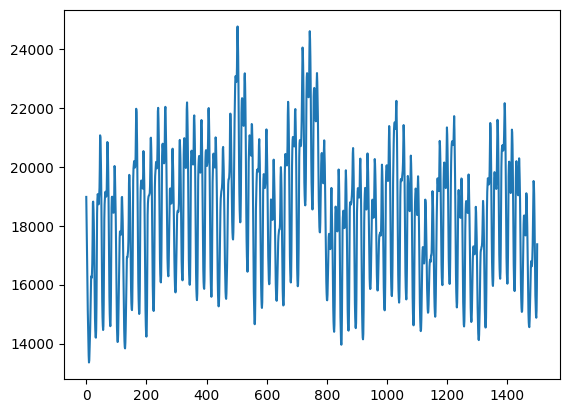

In [10]:
plt.plot(hour_load[:1500], label='load')

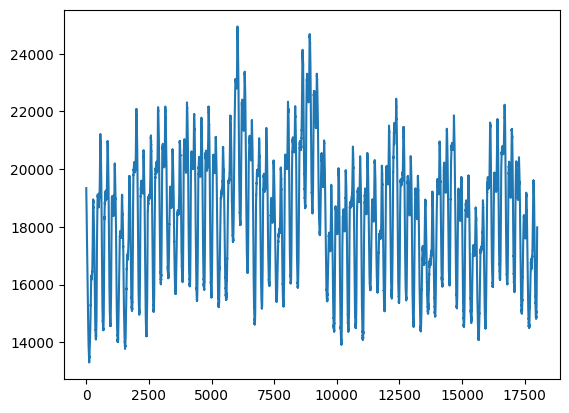

In [14]:
plt.plot(min_load[:1500*12], label='load')

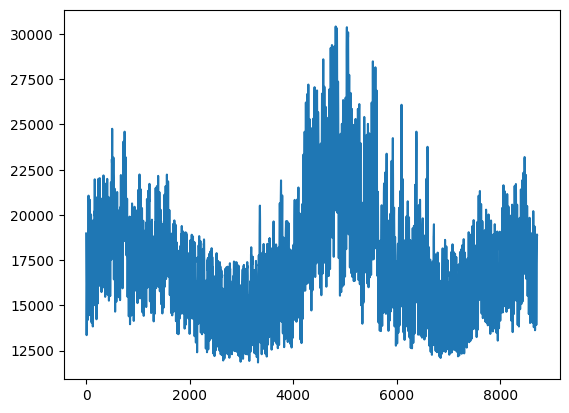

In [15]:
plt.plot(hour_load, label='load')

In [22]:
genfile = '/Users/hanshu/Desktop/Price_formation/Data/NYGrid/NY_gen.csv'
gen_df = pd.read_csv(genfile, index_col=0)
gen_df[gen_df.GEN_NAME == 'Brooklyn Navy Yard']

,GEN_NAME,PMAX,PMIN,RAMP_10,GEN_FUEL,PRIMEMOVER,Energy_Source_1 (Fuel),RAMP_min,StartUpCost,SimGEN_PERCidx,PERC_StartUpCost,MinDownTime,MinRunTime
Unnamed: 0,,,,,,,,,,,,,
57,Brooklyn Navy Yard,240.0,101.0,15.916667,Combined Cycle,CC,NG,1.591667,20000.0,198,19448.0,4.0,6.0


In [10]:
import pandas as pd
gen_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Result//Gen_commit.csv')
off_gen = gen_df[gen_df.commitment == False]
on_gen = gen_df[gen_df.commitment == True]

In [11]:
on_gen.describe().round(2)

,pg_min,pg_max,fixed_cost,startup_cost,variable_cost,minup,mindown,time_limits
count,162.00,162.00,162.00,162.00,162.00,162.00,162.00,162.00
mean,26.02,140.94,-28.03,4125.51,138.42,325.99,326.62,326.62
std,55.70,235.37,1446.30,8651.51,99.68,1659.18,1659.05,1659.05
min,0.00,0.10,-10127.00,0.00,1.20,1.00,0.00,0.00
25%,0.00,20.00,0.00,0.00,36.71,1.00,0.00,0.00
50%,0.00,43.00,0.00,0.00,110.12,1.00,0.00,0.00
75%,17.38,133.25,0.00,3766.98,236.21,2.00,4.00,4.00
max,271.00,1299.00,4739.00,61627.07,390.46,8760.00,8760.00,8760.00


In [12]:
off_gen.describe().round(2) 

,pg_min,pg_max,fixed_cost,startup_cost,variable_cost,minup,mindown,time_limits
count,71.00,71.00,71.00,71.00,71.00,71.00,71.00,71.00
mean,13.72,136.07,784.14,11066.69,138.51,1.56,2.38,2.38
std,24.11,225.22,1866.17,18626.94,92.70,0.50,2.07,2.07
min,0.00,2.00,-957.28,0.00,30.40,1.00,0.00,0.00
25%,0.00,18.30,0.00,2520.42,58.90,1.00,0.00,0.00
50%,1.00,43.00,26.64,2633.36,95.43,2.00,4.00,4.00
75%,15.00,98.00,450.84,19448.00,236.21,2.00,4.00,4.00
max,111.00,1000.00,8873.70,98278.00,309.90,2.00,6.00,6.00


In [9]:
sort_df = gen_df.sort_values(by='startup_cost')
pd.set_option('display.max_rows', None)
sort_df

,Gen,pg_min,pg_max,fixed_cost,startup_cost,variable_cost,minup,mindown,time_limits,commitment
0,Gowanus 2-5,0.00,20.0,0.0000,0.00,236.2100,1.0,0.0,0.0,True
151,Athens 3,269.45,392.0,-25.7280,0.00,30.5320,2.0,6.0,6.0,True
87,Gowanus 1-4,0.00,20.0,0.0000,0.00,236.2100,1.0,0.0,0.0,True
86,Gowanus 5,19.00,44.0,-2200.2000,0.00,106.3300,1.0,0.0,0.0,True
154,Gowanus 1-7,0.00,20.0,0.0000,0.00,236.2100,1.0,0.0,0.0,True
156,St. Elizabeth Medical Center,0.00,0.6,0.0000,0.00,38.2660,1.0,0.0,0.0,True
157,Astoria GT 3-4,0.00,46.0,0.0000,0.00,236.2100,2.0,4.0,4.0,True
159,Holtsville 01,1.00,17.0,39.0800,0.00,305.1600,2.0,4.0,4.0,False
162,Nuclear_B_0,0.00,581.7,0.0000,0.00,2.6294,8760.0,8760.0,8760.0,True
80,Shoreham 1,0.00,52.9,0.0000,0.00,236.2100,1.0,0.0,0.0,True
